In [87]:
import pandas as pd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import tree
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree

import gc
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

In [88]:
column_defs = pd.read_excel('data\LCDataDictionary.xlsx',index_col='LoanStatNew')
column_defs.columns

Index(['Description'], dtype='object')

In [89]:
def na_check(data):
    check = np.round(data.isna().sum().sort_values(ascending=False),2)
    return check

In [90]:
def column_info(col_name):
    return column_defs.loc[col_name]['Description']

In [91]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [113]:
df = pd.read_csv('data/preprocessed.csv')

In [114]:
reduce_mem_usage(df,int_cast=False)

  0%|          | 0/75 [00:00<?, ?it/s]

Memory usage of dataframe is 993.88 MB


100%|██████████| 75/75 [00:09<00:00,  7.56it/s]


Memory usage after optimization is: 631.116 MB
Decreased by 36.5%


,Unnamed: 0,Unnamed: 0.1,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,0,42536,10129454,12000.0,36 months,10.99%,392.799988,B,B2,4,...,0.0,4.0,100.000000,0.0,0.0,7137.0,18100.0,0.0,N,N
1,1,42537,10149488,4800.0,36 months,10.99%,157.100006,B,B2,2,...,0.0,0.0,100.000000,0.0,0.0,4136.0,25700.0,0.0,N,N
2,2,42538,10149342,27060.0,36 months,10.99%,885.500000,B,B2,10,...,0.0,1.0,100.000000,0.0,0.0,70186.0,35700.0,33054.0,N,N
3,3,42539,10148122,12000.0,36 months,7.62%,374.000000,A,A3,3,...,0.0,3.0,100.000000,0.0,0.0,46738.0,14800.0,53404.0,N,N
4,4,42540,10129477,14000.0,36 months,12.85%,470.799988,B,B4,4,...,0.0,0.0,78.599998,1.0,0.0,17672.0,3900.0,27340.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736932,1741058,2925488,102556443,24000.0,60 months,23.99%,690.500000,E,E2,1,...,1.0,2.0,87.500000,1.0,1.0,60812.0,28200.0,64422.0,N,N
1736933,1741059,2925489,102653304,10000.0,36 months,7.99%,313.200012,A,A5,10,...,0.0,2.0,92.599998,0.0,0.0,55863.0,34800.0,70203.0,N,N
1736934,1741060,2925490,102628603,10050.0,36 months,16.99%,358.200012,D,D1,8,...,0.0,5.0,95.199997,0.0,0.0,14300.0,9000.0,0.0,N,N
1736935,1741061,2925491,102196576,6000.0,36 months,11.44%,197.800003,B,B4,5,...,0.0,1.0,94.400002,0.0,0.0,26201.0,8100.0,34076.0,N,N


In [18]:
for col in df.columns:
    print(col)
    print(column_info(col))
    print(df[col].value_counts(normalize = True, ascending=False).head(3))
    print("-------------------------------------------------------------")

id
A unique LC assigned ID for the loan listing.
4196351      5.757261e-07
75101579     5.757261e-07
137966995    5.757261e-07
Name: id, dtype: float64
-------------------------------------------------------------
loan_amnt
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
10000.0    0.078220
20000.0    0.054624
12000.0    0.053229
Name: loan_amnt, dtype: float64
-------------------------------------------------------------
term
The number of payments on the loan. Values are in months and can be either 36 or 60.
 36 months    0.748299
 60 months    0.251701
Name: term, dtype: float64
-------------------------------------------------------------
int_rate
Interest Rate on the loan
  5.32%    0.023535
 10.99%    0.023520
 11.99%    0.023327
Name: int_rate, dtype: float64
-------------------------------------------------------------
installment
The monthly payment owed

N    0.999073
Y    0.000927
Name: hardship_flag, dtype: float64
-------------------------------------------------------------
debt_settlement_flag
Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.
N    0.971706
Y    0.028294
Name: debt_settlement_flag, dtype: float64
-------------------------------------------------------------


In [94]:
df.drop(columns=['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

Have cleaned for NA values but after baseline model we need to drop more variables as our model is overfitting

will look to drop features that are not relevant to performance of the loans as they are not available at time of application approval

Payment plan and out_principal only have 1 value so dropping

In [95]:
df.drop(columns=['pymnt_plan','out_prncp'],axis=1,inplace=True)

In [96]:
post_app_drops = ['total_bal_ex_mort', 'pct_tl_nvr_dlq','num_tl_op_past_12m','num_tl_90g_dpd_24m','num_tl_30dpd'
,'num_tl_120dpd_2m','num_bc_sats','num_accts_ever_120_pd','mths_since_recent_bc','mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op'
,'chargeoff_within_12_mths','bc_util','avg_cur_bal','tot_cur_bal','tot_coll_amt','acc_now_delinq','collections_12_mths_ex_med'
,'last_fico_range_low','last_fico_range_high','last_credit_pull_d','last_pymnt_amnt','last_pymnt_d','recoveries','total_rec_late_fee'
,'total_rec_int','total_rec_prncp','total_pymnt','revol_util','revol_bal']

In [15]:
for x in post_app_drops:
    print('{}: {}'.format(x,column_info(x)))

total_bal_ex_mort: Total credit balance excluding mortgage
pct_tl_nvr_dlq: Percent of trades never delinquent
num_tl_op_past_12m: Number of accounts opened in past 12 months
num_tl_90g_dpd_24m: Number of accounts 90 or more days past due in last 24 months
num_tl_30dpd: Number of accounts currently 30 days past due (updated in past 2 months)
num_tl_120dpd_2m: Number of accounts currently 120 days past due (updated in past 2 months)
num_bc_sats: Number of satisfactory bankcard accounts
num_accts_ever_120_pd: Number of accounts ever 120 or more days past due
mths_since_recent_bc: Months since most recent bankcard account opened.
mo_sin_rcnt_tl: Months since most recent account opened
mo_sin_rcnt_rev_tl_op: Months since most recent revolving account opened
mo_sin_old_rev_tl_op: Months since oldest revolving account opened
chargeoff_within_12_mths: Number of charge-offs within 12 months
bc_util: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
avg_cur_ba

In [97]:
df.drop(columns=post_app_drops,axis=1,inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736937 entries, 0 to 1736936
Data columns (total 40 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id                          int32  
 1   loan_amnt                   float32
 2   term                        object 
 3   int_rate                    object 
 4   installment                 float32
 5   grade                       object 
 6   sub_grade                   object 
 7   emp_length                  int8   
 8   home_ownership              object 
 9   annual_inc                  float32
 10  verification_status         object 
 11  issue_d                     object 
 12  loan_status                 object 
 13  purpose                     object 
 14  title                       object 
 15  zip_code                    object 
 16  addr_state                  object 
 17  dti                         float32
 18  delinq_2yrs                 float32
 19  earliest_cr_line     

In [13]:
for col in df.columns:
    print(col)
    print(column_info(col))
    print(df[col].value_counts(normalize = True, ascending=False).head(3))
    print("-------------------------------------------------------------")

id
A unique LC assigned ID for the loan listing.
4196351      5.757261e-07
75101579     5.757261e-07
137966995    5.757261e-07
Name: id, dtype: float64
-------------------------------------------------------------
loan_amnt
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
10000.0    0.078220
20000.0    0.054624
12000.0    0.053229
Name: loan_amnt, dtype: float64
-------------------------------------------------------------
term
The number of payments on the loan. Values are in months and can be either 36 or 60.
 36 months    0.748299
 60 months    0.251701
Name: term, dtype: float64
-------------------------------------------------------------
int_rate
Interest Rate on the loan
  5.32%    0.023535
 10.99%    0.023520
 11.99%    0.023327
Name: int_rate, dtype: float64
-------------------------------------------------------------
installment
The monthly payment owed

N    0.999073
Y    0.000927
Name: hardship_flag, dtype: float64
-------------------------------------------------------------
debt_settlement_flag
Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.
N    0.971706
Y    0.028294
Name: debt_settlement_flag, dtype: float64
-------------------------------------------------------------


In [30]:
df.sub_grade

0          B2
1          B2
2          B2
3          A3
4          B4
           ..
1736932    E2
1736933    A5
1736934    D1
1736935    B4
1736936    E4
Name: sub_grade, Length: 1736937, dtype: object

In [98]:
df.drop(columns=["debt_settlement_flag", "hardship_flag",'id'],axis=1,inplace=True)

In [99]:
# making average fico score and dropping the fico range high and low
df['average_fico'] = (df['fico_range_high'] + df['fico_range_low'])/2
df.drop(columns=['fico_range_high','fico_range_low'],axis=1,inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736937 entries, 0 to 1736936
Data columns (total 36 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float32
 1   term                        object 
 2   int_rate                    object 
 3   installment                 float32
 4   grade                       object 
 5   sub_grade                   object 
 6   emp_length                  int8   
 7   home_ownership              object 
 8   annual_inc                  float32
 9   verification_status         object 
 10  issue_d                     object 
 11  loan_status                 object 
 12  purpose                     object 
 13  title                       object 
 14  zip_code                    object 
 15  addr_state                  object 
 16  dti                         float32
 17  delinq_2yrs                 float32
 18  earliest_cr_line            object 
 19  inq_last_6mths       

Export to csv from here rest is seeing if improvement to baseline

In [100]:
df.drop('initial_list_status',axis=1,inplace=True)

In [101]:
df.drop('title',axis=1,inplace=True)

In [102]:
df.drop(columns=['zip_code'],axis=1,inplace=True)


In [103]:
df.int_rate = df.int_rate.map(lambda x: float(x.replace('%','')))

In [28]:
df.loan_status.value_counts()

Fully Paid     1399842
Charged Off     337095
Name: loan_status, dtype: int64

## Addr State

Here converting states to regions as using state dummy variables creates 50 variables

In [104]:
regions = pd.read_excel('data/state_regions.xlsx')

In [105]:
df.addr_state

0          NC
1          TX
2          MI
3          TX
4          NC
           ..
1736932    CO
1736933    PA
1736934    VA
1736935    NY
1736936    TX
Name: addr_state, Length: 1736937, dtype: object

In [106]:
df.addr_state.iloc[0]

'NC'

In [107]:
regions[regions['State Code'] == 'AK']['Region']

0    West
Name: Region, dtype: object

In [108]:
df['region'] = df.addr_state.apply(lambda x: regions.loc[regions['State Code'] == x]['Region'].values[0])

In [109]:
df.region.value_counts()

South        621948
West         456308
Northeast    349635
Midwest      309046
Name: region, dtype: int64

In [111]:
df.drop(columns = ['addr_state'],axis=1,inplace=True)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736937 entries, 0 to 1736936
Data columns (total 34 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float32
 1   term                        object 
 2   int_rate                    float64
 3   installment                 float32
 4   grade                       object 
 5   sub_grade                   object 
 6   emp_length                  int8   
 7   home_ownership              object 
 8   annual_inc                  float32
 9   verification_status         object 
 10  issue_d                     object 
 11  loan_status                 object 
 12  purpose                     object 
 13  addr_state                  object 
 14  dti                         float32
 15  delinq_2yrs                 float32
 16  earliest_cr_line            object 
 17  inq_last_6mths              float32
 18  pub_rec                     float32
 19  total_acc            

In [112]:
df.to_csv('data/full_clean')

## Baseline Test

In [83]:
df.drop(columns = ['regions','addr_state'],axis=1,inplace=True)

In [20]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'title', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'pub_rec',
       'total_acc', 'application_type', 'acc_open_past_24mths', 'delinq_amnt',
       'mort_acc', 'mths_since_recent_inq', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'pub_rec_bankruptcies', 'tax_liens', 'total_bc_limit',
       'total_il_high_credit_limit', 'average_fico'],
      dtype='object')

In [22]:
objects = list(df.loc[:,df.dtypes == 'object'].columns)
objects

['term',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'addr_state',
 'earliest_cr_line',
 'application_type']

In [48]:
categorical =['term',
 'sub_grade','grade',
 'home_ownership',
 'verification_status',
 'purpose','application_type','region']

drop = ['issue_d','earliest_cr_line']
cat_drop = ['term',
 'sub_grade',,'grade'
 'home_ownership',
 'verification_status',
 'purpose',
 'region','application_type','issue_d','earliest_cr_line']
cat_drop1 = ['term',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'region','application_type','issue_d','earliest_cr_line','loan_status']

In [25]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

In [29]:
onehot = pd.get_dummies(df[categorical],drop_first=True)

In [59]:
cont = df.drop(columns=cat_drop1)

In [62]:
encoded = pd.concat([cont,onehot],axis=1)

In [60]:
cont.describe()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,total_acc,...,mort_acc,mths_since_recent_inq,num_bc_tl,num_il_tl,num_op_rev_tl,pub_rec_bankruptcies,tax_liens,total_bc_limit,total_il_high_credit_limit,average_fico
count,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,...,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06,1.736937e+06
mean,1.471386e+04,1.316545e+01,4.440634e+02,6.043523e+00,7.794385e+04,1.872237e+01,3.168060e-01,6.059460e-01,2.143025e-01,2.474883e+01,...,1.610573e+00,6.832294e+00,7.946541e+00,8.556044e+00,8.310472e+00,1.364966e-01,5.154936e-02,2.286305e+04,4.329260e+04,6.992207e+02
std,8.986702e+03,4.840233e+00,2.674402e+02,3.578266e+00,1.207552e+05,1.317191e+01,8.813928e-01,8.966404e-01,5.989000e-01,1.207613e+01,...,1.945146e+00,5.879927e+00,4.741576e+00,7.406231e+00,4.627765e+00,3.775918e-01,3.989700e-01,2.253990e+04,4.444642e+04,3.250732e+01
min,1.000000e+03,5.310000e+00,4.930000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.620000e+02
25%,8.000000e+03,9.490000e+00,2.502000e+02,2.000000e+00,4.687200e+04,1.196000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,...,0.000000e+00,2.000000e+00,5.000000e+00,4.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,8.300000e+03,1.500000e+04,6.720000e+02
50%,1.200000e+04,1.269000e+01,3.768000e+02,6.000000e+00,6.500000e+04,1.786000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,...,1.000000e+00,5.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,1.600000e+04,3.247300e+04,6.920000e+02
75%,2.000000e+04,1.599000e+01,5.900000e+02,1.000000e+01,9.300000e+04,2.448000e+01,0.000000e+00,1.000000e+00,0.000000e+00,3.200000e+01,...,3.000000e+00,1.000000e+01,1.000000e+01,1.100000e+01,1.100000e+01,0.000000e+00,0.000000e+00,2.970000e+04,5.816000e+04,7.170000e+02
max,4.000000e+04,3.099000e+01,1.720000e+03,1.000000e+01,1.100000e+08,9.990000e+02,3.900000e+01,8.000000e+00,8.600000e+01,1.760000e+02,...,6.100000e+01,2.500000e+01,8.900000e+01,1.590000e+02,8.300000e+01,1.200000e+01,8.500000e+01,1.569000e+06,2.101913e+06,8.475000e+02


In [120]:
na_check(df)

average_fico                  0
total_il_high_credit_limit    0
term                          0
int_rate                      0
installment                   0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
pub_rec                       0
total_acc                     0
application_type              0
acc_open_past_24mths          0
delinq_amnt                   0
mort_acc                      0
mths_since_recent_inq         0
num_bc_tl                     0
num_il_tl                     0
num_op_rev_tl                 0
pub_rec_bankruptcies          0
tax_liens                     0
total_bc_limit                0
loan_amn

In [ ]:
smote= SMOTE()
x_smote,y_smote = smote.fit_sample(x_train,y_train)
x_train_sig = 

In [40]:
x = encoded.drop(columns='loan_status',axis=1)
y = df['loan_status'].map(lambda x: 1 if x =="Charged Off" else 0)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25)

## Sigmoid scaled no smote

In [ ]:
x_train_sig = x_train

In [63]:
x_train, x_test, y_train, y_test = train_test_split(encoded,y,test_size=.25)

In [98]:
x_train_sig = x_train.apply(sigmoid)
x_test_sig = x_test.apply(sigmoid)

AUC: 0.7032559149668175
[[347081   2601]
 [ 81577   2976]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    349682
           1       0.53      0.04      0.07     84553

    accuracy                           0.81    434235
   macro avg       0.67      0.51      0.48    434235
weighted avg       0.76      0.81      0.73    434235



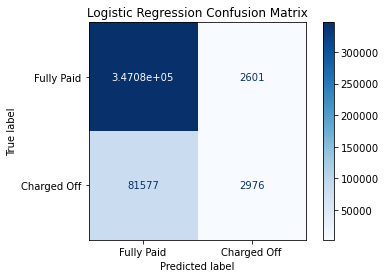

In [89]:
logreg = LogisticRegression(C=1,fit_intercept=True,solver='lbfgs')
log_model = logreg.fit(x_train_sig, y_train)
y_hat_log = logreg.predict(x_test_sig)
y_score_log = log_model.decision_function(x_test_sig)
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,x_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log))

In [42]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [97]:
def sigmoid(x):
    return 1/(1 + np.e**(-1*x))

In [ ]:
result.

In [68]:
logit_model=sm.Logit(y_train,x_train_sig)
result=logit_model.fit(method='bfgs',maxiter=100)
print(result.summary())

         Current function value: 0.453415
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103


C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              1302702
Model:                          Logit   Df Residuals:                  1302574
Method:                           MLE   Df Model:                          127
Date:                Mon, 05 Apr 2021   Pseudo R-squ.:                 0.07800
Time:                        18:44:17   Log-Likelihood:            -5.9066e+05
converged:                      False   LL-Null:                   -6.4063e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
loan_amnt                              -0.3091   2.08e+04  -1.48e-05      1.000   -4.08e+04    4.08e+04
int_rate                               -0.1012      9.68

## Min Max scaled no smote

In [69]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

AUC: 0.71129916559909
[[345830   3852]
 [ 79926   4627]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    349682
           1       0.55      0.05      0.10     84553

    accuracy                           0.81    434235
   macro avg       0.68      0.52      0.50    434235
weighted avg       0.76      0.81      0.74    434235



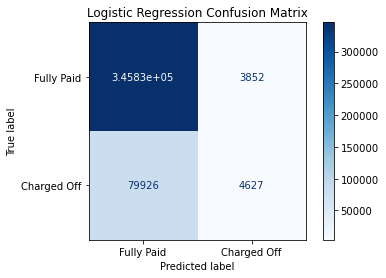

In [90]:
logreg = LogisticRegression(C=1,fit_intercept=True,solver='lbfgs')
log_model = logreg.fit(x_train_scaled, y_train)
y_hat_log = logreg.predict(x_test_scaled)
y_score_log = log_model.decision_function(x_test_scaled)
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log))

In [ ]:
logreg = LogisticRegression(C=1e12,fit_intercept=True,solver='lbfgs')
log_model = logreg.fit(x_train_scaled, y_train)
y_hat_log = logreg.predict(x_test_scaled)
y_score_log = log_model.decision_function(x_test_scaled)
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log))

In [78]:
pd.options.display.max_rows = 128

In [87]:
scaled_results = pd.DataFrame(zip(x_train.columns,result.params.values,np.round(result.pvalues.values,4)),columns=['features','coef','pvalues'])
scaled_results

,features,coef,pvalues
0,loan_amnt,-0.115929,0.0000
1,int_rate,0.059899,0.0000
2,installment,0.198262,0.0000
3,emp_length,-0.015526,0.0000
4,annual_inc,-0.024591,0.0000
5,dti,0.084440,0.0000
6,delinq_2yrs,0.023995,0.0000
7,inq_last_6mths,0.016792,0.0000
8,pub_rec,-0.003348,0.5359
9,total_acc,-0.137110,0.0000


In [82]:
result.pvalues.values

array([2.53280741e-016, 1.60032929e-011, 3.95619674e-051, 1.23391324e-016,
       1.80514515e-008, 2.43561337e-183, 7.58337735e-037, 4.33796465e-014,
       5.35947843e-001, 5.37520012e-095, 0.00000000e+000, 2.18035606e-001,
       2.36459041e-062, 3.74896536e-026, 2.21161158e-013, 3.74044655e-025,
       2.62874113e-088, 5.05450747e-004, 2.35708951e-001, 4.13959711e-112,
       8.17947427e-045, 1.60497734e-099, 0.00000000e+000, 8.62288758e-002,
       5.70968704e-003, 5.31558492e-003, 3.05388587e-002, 4.54290884e-001,
       6.14325784e-001, 5.01531870e-001, 1.68441450e-002, 3.15502886e-005,
       8.16976959e-010, 1.07747431e-014, 6.85297202e-018, 9.44487251e-026,
       3.36018693e-027, 2.54882038e-027, 2.78854095e-033, 2.67543432e-034,
       4.78016900e-036, 7.11246811e-035, 8.14104180e-038, 5.01254886e-040,
       5.01457604e-047, 7.84764003e-044, 1.09934279e-045, 1.12663332e-030,
       2.16122322e-042, 4.52326874e-031, 3.65458096e-042, 3.64787423e-037,
       7.25253208e-024, 5

In [73]:
logit_model=sm.Logit(y_train,x_train_scaled)
result=logit_model.fit(method='bfgs',maxiter=100)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.664410
         Iterations: 82
         Function evaluations: 83
         Gradient evaluations: 83
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              1302702
Model:                          Logit   Df Residuals:                  1302574
Method:                           MLE   Df Model:                          127
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                 -0.3511
Time:                        02:25:43   Log-Likelihood:            -8.6553e+05
converged:                       True   LL-Null:                   -6.4063e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1159      0.014     -

In [ ]:
smote= SMOTE()
x_smote,y_smote = smote.fit_sample(x_train,y_train)

In [99]:

x_train_smsig = x_smote.apply(sigmoid)

x_train_smscaled = scaler.fit_transform(x_smote)

## Log Smote 

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


AUC: 0.6888340766512712
[[344398   5284]
 [ 80289   4264]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.89    349682
           1       0.45      0.05      0.09     84553

    accuracy                           0.80    434235
   macro avg       0.63      0.52      0.49    434235
weighted avg       0.74      0.80      0.73    434235



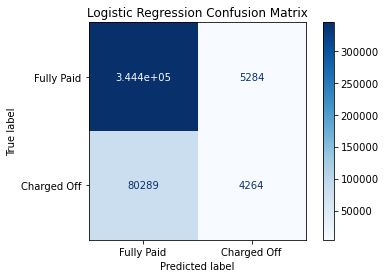

In [100]:
logreg = LogisticRegression(C=1e7,fit_intercept=True,solver='sag')
log_model = logreg.fit(x_train_smsig, y_smote)
y_hat_log = logreg.predict(x_test_sig)
y_score_log = log_model.decision_function(x_test_sig)
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,x_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log))

In [105]:
logit_model=sm.Logit(y_smote,x_train_smsig)
result=logit_model.fit(method='bfgs',maxiter=100)
print(result.summary())

         Current function value: 0.365074
         Iterations: 100
         Function evaluations: 103
         Gradient evaluations: 103


C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              2100320
Model:                          Logit   Df Residuals:                  2100192
Method:                           MLE   Df Model:                          127
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                  0.4733
Time:                        03:31:23   Log-Likelihood:            -7.6677e+05
converged:                      False   LL-Null:                   -1.4558e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
loan_amnt                               8.6440        nan        nan        nan         nan         nan
int_rate                                9.2080        na

## Scaled Smote

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


AUC: 0.6986879801984937
[[162967 186715]
 [ 17300  67253]]
              precision    recall  f1-score   support

           0       0.90      0.47      0.62    349682
           1       0.26      0.80      0.40     84553

    accuracy                           0.53    434235
   macro avg       0.58      0.63      0.51    434235
weighted avg       0.78      0.53      0.57    434235



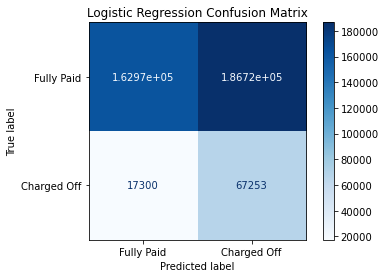

In [121]:
logreg = LogisticRegression(C=1e12,fit_intercept=False,solver='liblinear',penalty='l1',max_iter=200)
log_model = logreg.fit(x_train_smscaled, y_smote)
y_hat_log = logreg.predict(x_test_scaled)
y_score_log = log_model.decision_function(x_test_scaled)
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log)) 

In [ ]:
log

In [127]:
logit_model=sm.Logit(y_smote,x_train_smscaled)
result=logit_model.fit(method='lbfgs',maxiter=300)
print(result.summary())

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              2100320
Model:                          Logit   Df Residuals:                  2100192
Method:                           MLE   Df Model:                          127
Date:                Wed, 07 Apr 2021   Pseudo R-squ.:                  0.5840
Time:                        03:51:07   Log-Likelihood:            -6.0558e+05
converged:                       True   LL-Null:                   -1.4558e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3605        nan        nan        nan         nan         nan
x2             0.8966        nan        nan        nan         nan         nan
x3            -0.1496        nan        nan        n

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [126]:
pd.DataFrame(x_train_smscaled,columns=x_train.columns).describe()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,total_acc,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,application_type_Joint App
count,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,...,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06,2.100320e+06
mean,1.013553e-16,6.365493e-17,-3.274765e-18,-4.671276e-17,-2.648906e-17,-2.509119e-16,2.353094e-16,3.355957e-17,-8.836452e-17,4.684808e-17,...,2.928343e-17,-1.131282e-16,3.301829e-17,-7.469711e-18,-2.427656e-17,6.235585e-17,4.151644e-17,3.139444e-17,3.362723e-18,1.133989e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.576928e+00,-1.845820e+00,-1.700920e+00,-1.430622e+00,-5.469043e-01,-1.561032e+00,-3.897302e-01,-7.567492e-01,-3.898610e-01,-1.959963e+00,...,-1.014368e-01,-2.394074e-01,-6.709243e-02,-1.332689e-01,-3.614232e-02,-1.162450e-01,-9.188966e-02,-4.671741e-02,-3.639241e-02,-1.683588e-01
25%,-7.998116e-01,-6.713386e-01,-7.250330e-01,-8.386436e-01,-2.221268e-01,-5.102466e-01,-3.897302e-01,-7.567492e-01,-3.898610e-01,-7.459377e-01,...,-1.014368e-01,-2.394074e-01,-6.709243e-02,-1.332689e-01,-3.614232e-02,-1.162450e-01,-9.188966e-02,-4.671741e-02,-3.639241e-02,-1.683588e-01
50%,-2.075468e-01,-9.248727e-02,-2.462688e-01,4.932387e-02,-7.778118e-02,-5.098657e-02,-3.897302e-01,-5.784747e-01,-3.898610e-01,-1.389253e-01,...,-1.014368e-01,-2.394074e-01,-6.709243e-02,-1.332689e-01,-3.614232e-02,-1.162450e-01,-9.188966e-02,-4.671741e-02,-3.639241e-02,-1.683588e-01
75%,5.323876e-01,6.038122e-01,5.564958e-01,1.233281e+00,1.026508e-01,4.421198e-01,-3.284068e-01,4.023883e-01,-3.898610e-01,5.548032e-01,...,-1.014368e-01,-2.394074e-01,-6.709243e-02,-1.332689e-01,-3.614232e-02,-1.162450e-01,-9.188966e-02,-4.671741e-02,-3.639241e-02,-1.683588e-01
max,2.752720e+00,3.540015e+00,4.764545e+00,1.233281e+00,7.933537e+02,7.512994e+01,4.631846e+01,8.516350e+00,1.482084e+02,1.312863e+01,...,9.858351e+00,4.176980e+00,1.490481e+01,7.503624e+00,2.766840e+01,8.602522e+00,1.088262e+01,2.140530e+01,2.747826e+01,5.939694e+00


In [129]:
pd.DataFrame(x_train_scaled,columns=x_train.columns).describe()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,total_acc,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,application_type_Joint App
count,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,...,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06,1.302702e+06
mean,3.830063e-17,1.374985e-16,-3.542618e-17,-2.438652e-17,-4.310355e-17,-1.345049e-16,1.894714e-18,1.046422e-17,1.929963e-17,3.411167e-17,...,2.589056e-17,-2.566830e-17,3.788883e-17,1.777854e-17,-8.225200e-18,-2.235476e-17,5.093842e-17,-8.616551e-18,3.011361e-17,-9.348256e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.525434e+00,-1.622500e+00,-1.641543e+00,-1.409350e+00,-5.925288e-01,-1.491245e+00,-3.599569e-01,-6.761882e-01,-3.585806e-01,-1.884569e+00,...,-1.284996e-01,-3.001800e-01,-8.511670e-02,-1.685735e-01,-4.585988e-02,-1.475912e-01,-1.164633e-01,-5.930074e-02,-4.621988e-02,-1.962148e-01
25%,-7.465492e-01,-7.588892e-01,-7.247475e-01,-1.129870e+00,-2.358661e-01,-5.120570e-01,-3.599569e-01,-6.761882e-01,-3.585806e-01,-7.248027e-01,...,-1.284996e-01,-3.001800e-01,-8.511670e-02,-1.685735e-01,-4.585988e-02,-1.475912e-01,-1.164633e-01,-5.930074e-02,-4.621988e-02,-1.962148e-01
50%,-3.014723e-01,-9.775183e-02,-2.520840e-01,-1.195406e-02,-9.837554e-02,-6.518439e-02,-3.599569e-01,-6.761882e-01,-3.585806e-01,-1.449195e-01,...,-1.284996e-01,-3.001800e-01,-8.511670e-02,-1.685735e-01,-4.585988e-02,-1.475912e-01,-1.164633e-01,-5.930074e-02,-4.621988e-02,-1.962148e-01
75%,5.886815e-01,5.840460e-01,5.462837e-01,1.105962e+00,1.144905e-01,4.353733e-01,-3.599569e-01,4.385627e-01,-3.585806e-01,6.006447e-01,...,-1.284996e-01,-3.001800e-01,-8.511670e-02,-1.685735e-01,-4.585988e-02,-1.475912e-01,-1.164633e-01,-5.930074e-02,-4.621988e-02,-1.962148e-01
max,2.814066e+00,3.683127e+00,4.771836e+00,1.105962e+00,8.356668e+02,7.412171e+01,4.392073e+01,8.241820e+00,1.434829e+02,1.252967e+01,...,7.782124e+00,3.331334e+00,1.174858e+01,5.932132e+00,2.180555e+01,6.775473e+00,8.586397e+00,1.686320e+01,2.163571e+01,5.096454e+00


In [134]:
y_train.value_counts()

0    1050160
1     252542
Name: loan_status, dtype: int64